In [1]:
import sklearn, leidenalg, itertools, random
import pandas as pd
import numpy as np
import igraph as ig
import sklearn.neighbors
import scipy as sp
from statsmodels.stats.multitest import multipletests
import gseapy as gp

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
PRmatrix=pd.read_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/metabolomics_data_HIV_correlations.csv')
PRmatrix.shape

(703749, 5)

In [4]:
PRmatrix.loc[PRmatrix['Padj']<0.02,'R'].shape

(16672,)

In [5]:
PRmatrix = PRmatrix.loc[PRmatrix['Padj']<0.02,]

In [6]:
# Prepares table for being read by igraph
PRmatrix=PRmatrix.loc[PRmatrix['R']!=0,['feat1','feat2','R']]
PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2] #drops self correlations

fdr_pos_mat=PRmatrix.loc[PRmatrix['R']>0]

fdr_neg_mat=PRmatrix.loc[PRmatrix['R']<0]

PRmatrix=PRmatrix.loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,]

In [7]:
fdr_pos_mat.to_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/network_correlation_positive.csv', index=False)
fdr_pos_mat.to_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/network_correlation_positive.txt', sep='\t', mode='a')
fdr_pos_mat.shape
fdr_pos_mat.to_excel('/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/network_correlation_positive.xlsx', index = False)

/home/flomik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


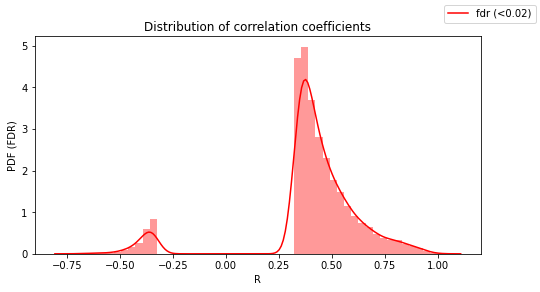

In [8]:
shortPR=PRmatrix.copy().loc[:,['feat1','feat2','R']]
shortPR=shortPR.loc[shortPR.feat1!=shortPR.feat2]

fig=plt.figure(figsize=(8,4))
g=sns.distplot(shortPR['R'][shortPR['R']!=0], color='r');
g.set(ylabel='PDF (FDR)')

fig.legend(labels=['fdr (<0.02)']);
plt.xlabel('R')
plt.title('Distribution of correlation coefficients')
plt.savefig('/home/flomik/Desktop/Code-PHD/3_layers_integration/results/network/3_layers_integration_distribution_corr_coeff.svg', format='svg', dpi=1200)

plt.show()

In [9]:
fdr_pos_mat.shape

(15490, 3)

In [12]:
pos_w=ig.Graph.TupleList([tuple(x) for x in fdr_pos_mat.values], directed=False, edge_attrs=['w'])

#negative association, weighted
neg_w=ig.Graph.TupleList([tuple(x) for x in fdr_neg_mat.values], directed=False, edge_attrs=['w'])

#random network, unweighted, node and edge number based on a network of the same size
randomG=ig.Graph.Erdos_Renyi(
    n=pos_w.vcount(), 
    m=pos_w.ecount(), directed=False, loops=False)

randomG_2=ig.Graph.Erdos_Renyi(
    n=neg_w.vcount(), 
    m=neg_w.ecount(), directed=False, loops=False)

In [13]:
#function to get graph properties, takes a few minutes to run
def graph_prop(input_graph):
    ncount=nn.vcount()
    ecount=nn.ecount()
    diameter=nn.diameter()
    av_path=nn.average_path_length()
    dens=nn.density()
    clustering=nn.transitivity_undirected() #this is the global clustering coefficient
    conn=nn.is_connected()
    min_cut=nn.mincut_value()
    out=pd.DataFrame([ncount, ecount, diameter, av_path, dens, clustering, conn, min_cut],
                 index=['node_count','edge_count','diameter','av_path_length','density','clustering_coef','connected?','minimum_cut']).T
    return(out)

#summarizing graph properties
network_stats=pd.DataFrame()
for nn in [pos_w, neg_w, randomG, randomG_2]:
    network_stats=pd.concat([network_stats,graph_prop(nn)])
    
network_stats.index=['pos_w','neg_w', 'random', 'random_2']
network_stats

,node_count,edge_count,diameter,av_path_length,density,clustering_coef,connected?,minimum_cut
pos_w,843,15490,10,3.010849,0.043646,0.552596,False,0.0
neg_w,535,1182,12,5.0157,0.008275,0.0,False,0.0
random,843,15490,3,2.149038,0.043646,0.043526,True,21.0
random_2,535,1182,9,4.359762,0.008275,0.007497,False,0.0


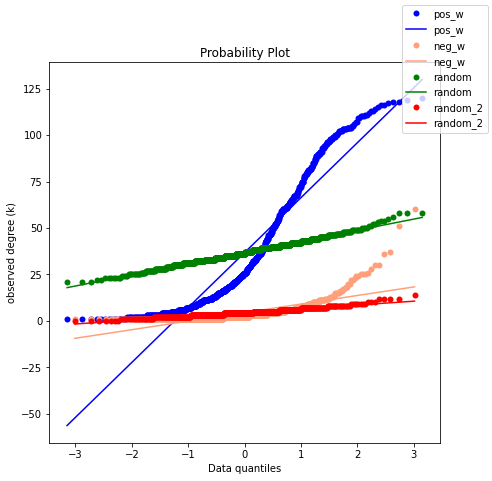

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
# ax.set(yscale='log', xscale='log')
p=sp.stats.probplot(pos_w.degree(), plot=ax)
k=sp.stats.probplot(neg_w.degree(), plot=ax)
r=sp.stats.probplot(randomG.degree(), plot=ax)
s=sp.stats.probplot(randomG_2.degree(), plot=ax)

col=['blue','','lightsalmon','','green', '','red']
for x in np.arange(0,7,2):
    ax.get_lines()[x].set_markerfacecolor(col[x])
    ax.get_lines()[x].set_markeredgewidth(0)
    ax.get_lines()[x+1].set_color(col[x])


fig.legend(labels=['pos_w','pos_w','neg_w','neg_w','random','random', 'random_2','random_2']);

ax.set(xlabel='Data quantiles', ylabel='observed degree (k)')
plt.savefig('/home/flomik/Desktop/Code-PHD/3_layers_integration/results/network/3_layers_integration_Networks_degree.svg', format='svg', dpi=1200)
plt.show()

In [15]:
pos_w_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition, weights='w')

In [16]:
frame =pd.read_csv("/home/flomik/Desktop/Code-PHD/3_layers_integration/data/metabolites_HMDB_KEGG.csv")
frame

,BIOCHEMICAL,KEGG,Group HMDB
0,phosphate,C00009,HMDB01429
1,AMP,C00020,HMDB00045
2,S-adenosylhomocysteine (SAH),C00021,HMDB00939
3,pyruvate,C00022,HMDB00243
4,glutamate,C00025,HMDB00148
...,...,...,...
1138,X - 25790,NaN,NaN
1139,X - 25810,NaN,NaN
1140,X - 25828,NaN,NaN
1141,X - 25948,NaN,NaN


In [17]:
frame = frame.rename(columns={'BIOCHEMICAL': 'Node_2', 'KEGG': 'Node_1'})
frame

,Node_2,Node_1,Group HMDB
0,phosphate,C00009,HMDB01429
1,AMP,C00020,HMDB00045
2,S-adenosylhomocysteine (SAH),C00021,HMDB00939
3,pyruvate,C00022,HMDB00243
4,glutamate,C00025,HMDB00148
...,...,...,...
1138,X - 25790,NaN,NaN
1139,X - 25810,NaN,NaN
1140,X - 25828,NaN,NaN
1141,X - 25948,NaN,NaN


In [24]:
def Average(lst): 
    return sum(lst) / len(lst)

In [22]:
com_net = [pos_w_comm]

for i in com_net[0]:
    print(len(i))

168
143
140
129
103
51
48
28
27
4
2


167

In [28]:
## MSEA + centrality

network =[]
community = []
connectivity = []
communities_stats = []
n_metabolites = []
transitivity = []
tot_terms_enriched = []
tot_terms_enriched_2 = []
tot_nb =[]
tot_kegg = []
kegg = ['1']
c = 0

d = pd.DataFrame()

net = [pos_w]
com_net = [pos_w_comm]
names = ['pos_w']

for j in [0]:
    average = []
    a = 1
    terms_enriched = []
    for i in range(len(com_net[0])):
        if(len(com_net[0][i])<30):
            print(i)
            print(len(com_net[0][i]))
            continue
        print(i)
        c = com_net[0][i]
        kegg = ['1']
        tot_kegg = []
        degree = pd.Series(net[j].degree())
        metabolites = pd.Series(net[j].vs['name'])
        degree = degree[c]
        metabolites = metabolites[c]
        metabolites = metabolites.tolist()
        #for i in metabolites:
        #    print(i)
        #    subframe = frame[frame['Node_2'].str.contains(i)]
        #    if subframe.empty:
        #            continue
        #    kegg = subframe['Node_1'].tolist()
        #    print(kegg)
        #    #kegg = ' '.join(kegg)
        #    tot_kegg = tot_kegg + kegg
        #name = ['/home/flomik/Desktop/Code-PHD/Covid_Iceland/results/network/', names[j], str(a), 'metabolites.csv']
        #name = ''.join(name)
        #print(name)
        #name_2 = ['/home/flomik/Desktop/Code-PHD/Covid_Iceland/results/network/', names[j],  str(a), 'kegg_metabolites.csv']
        #name_2 = ''.join(name_2)
        #print(name_2)
        #df = pd.DataFrame(data={"col1": metabolites})
        #df_2 = pd.DataFrame(data={"col1": tot_kegg})
        #df.to_csv(name, index=False)
        #df_2.to_csv(name_2, index=False)
        #tot_kegg = [x for x in tot_kegg if x == x]
        #enr_2 = gp.enrichr(gene_list= tot_kegg,description= "KEGG_com_" + str(a),
        #               gene_sets ='/home/flomik/Desktop/Code-PHD/Association_analysis/extra/Metabo_KEGG.gmt',
        #               outdir='/home/flomik/Desktop/Code-PHD/Covid_Iceland/results/MSEA_KEGG',cutoff=0.5,verbose=True, background  = 846)
        #print(enr_2)
        #if enr_2.results.empty:
        #    continue
        #results_2=enr_2.results.sort_values('Adjusted P-value', ascending=True)
        #results_2=results_2.loc[results_2['Adjusted P-value']<0.1,]
        #terms_enriched_2 = results_2['Term'].tolist()
        #terms_enriched_2 = terms_enriched_2
        #terms_enriched_2 = ','.join(terms_enriched_2)
        #tot_terms_enriched_2.append(terms_enriched_2)
        #enr = gp.enrichr(gene_list= metabolites,description= "Metabolon_com_" + str(a),
        #               gene_sets="/home/flomik/Desktop/Code-PHD/3_layers_integration/processing/Metabolon_met.gmt",
        #               outdir='/home/flomik/Desktop/Code-PHD/3_layers_integration/results/MSEA_Metabolon',cutoff=0.5,verbose=True, background  = 879)
        #results=enr.results.sort_values('Adjusted P-value', ascending=True)
        #results=results.loc[results['Adjusted P-value']<0.05,]
        
        #nb = results['Overlap'].tolist()
        #nb = nb
        #nb = ','.join(nb)
        #tot_nb.append(nb)
        
        #terms_enriched = results['Term'].tolist()
        #terms_enriched = terms_enriched
        #terms_enriched = ','.join(terms_enriched)
        #tot_terms_enriched.append(terms_enriched)
        print("average connectivity of the community number ", a, "which contains", len(c), " metabolites is", round(Average(degree), 2), "for network", names[j])
        
        average.append(Average(degree))
        communities_stats.append((a,len(c),round(Average(degree), 2)))
        network.append(names[j])
        connectivity.append(round(Average(degree), 2))
        community.append(a)
        n_metabolites.append(len(c))
        v = net[j].transitivity_local_undirected(vertices = metabolites)
        transitivity.append(round(Average(v), 2))
        a = a +1
        
df = pd.DataFrame({'Network_name':network,
                   'Connectivity':connectivity,
                   'Number_community':community,
                   'N_metabolites':n_metabolites,
                   'Clustering_coeff':transitivity,
                   #'Terms_Metabolon':tot_terms_enriched,
                   #'Nb_metabolites_Metabolon':tot_nb,
                   #'Terms_KEGG':tot_terms_enriched_2,
                  })




df.to_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/results/network/Results_centrality_networks_3_layers_integration.csv', index=False)


0
average connectivity of the community number  1 which contains 168  metabolites is 43.37 for network pos_w
1
average connectivity of the community number  2 which contains 143  metabolites is 72.98 for network pos_w
2
average connectivity of the community number  3 which contains 140  metabolites is 33.07 for network pos_w
3
average connectivity of the community number  4 which contains 129  metabolites is 19.28 for network pos_w
4
average connectivity of the community number  5 which contains 103  metabolites is 40.32 for network pos_w
5
average connectivity of the community number  6 which contains 51  metabolites is 14.86 for network pos_w
6
average connectivity of the community number  7 which contains 48  metabolites is 11.29 for network pos_w
7
28
8
27
9
4
10
2


In [29]:
df

,Network_name,Connectivity,Number_community,N_metabolites,Clustering_coeff
0,pos_w,43.37,1,168,NaN
1,pos_w,72.98,2,143,NaN
2,pos_w,33.07,3,140,NaN
3,pos_w,19.28,4,129,0.43
4,pos_w,40.32,5,103,NaN
5,pos_w,14.86,6,51,NaN
6,pos_w,11.29,7,48,0.49


In [30]:
df_1 = pd.DataFrame({'Metabolites_names':['1'],
                   'Degree': ['1'],
                   'Network':['1'],
                   'Community':['1'],
                  })

df_1

,Metabolites_names,Degree,Network,Community
0,1,1,1,1


In [31]:
net = [pos_w]
com_net = [pos_w_comm]
names = ['pos_w']

for j in [0]:
    average = []
    a = 1
    for i in com_net[j]:
        tot_metabolites =[]
        tot_degree = []
        tot_network = []
        community = []
        if(len(i)<30):
            continue
        c = i
        degree = pd.Series(net[j].degree())
        metabolites = pd.Series(net[j].vs['name'])
        degree = degree[c]
        degree = degree.tolist()
        metabolites = metabolites[c]
        metabolites = metabolites.tolist()
        tot_network = [names[j]]*len(c)
        community = [a]*len(c)
        tot_degree = degree
        tot_metabolites = metabolites
        df_2 = pd.DataFrame({'Metabolites_names':tot_metabolites,
                   'Degree': tot_degree,
                   'Network': tot_network,
                   'Community':community,
                  }, columns = ['Metabolites_names', 'Degree', 'Network', 'Community'])
        df_1 = pd.concat([df_1, df_2], sort=False)
        a = a +1

        
df_1
df_1.to_csv('/home/flomik/Desktop/Code-PHD/3_layers_integration/results/network/Table_nodes_3_layers_integration.csv', index=False)

In [32]:
df_1

,Metabolites_names,Degree,Network,Community
0,1,1,1,1
0,4-methyl-2-oxopentanoate,58,pos_w,1
1,8-methoxykynurenate,79,pos_w,1
2,S-1-pyrroline-5-carboxylate,43,pos_w,1
3,N6-acetyllysine,86,pos_w,1
...,...,...,...,...
43,pyridoxal,11,pos_w,7
44,carotene diol (2),5,pos_w,7
45,cortisol,2,pos_w,7
46,"N,N-dimethylalanine",2,pos_w,7
